# EDA on processed data to understand the dataset, and uncover patterns before using the data for modelling



In [10]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math

warnings.filterwarnings("ignore")
sns.set_theme()

file_path = r"..\data\processed\cleaned-telco-customer-churn.csv"
df = pd.read_csv(file_path)


### Numerical Features

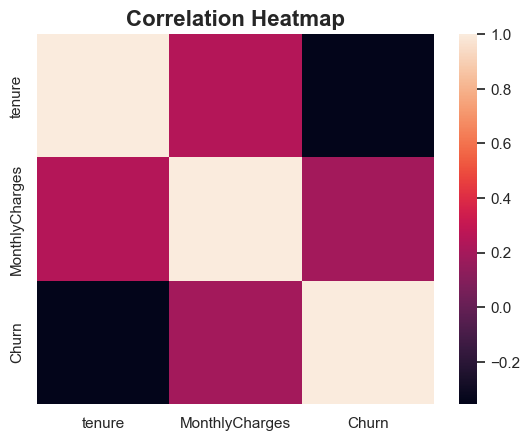

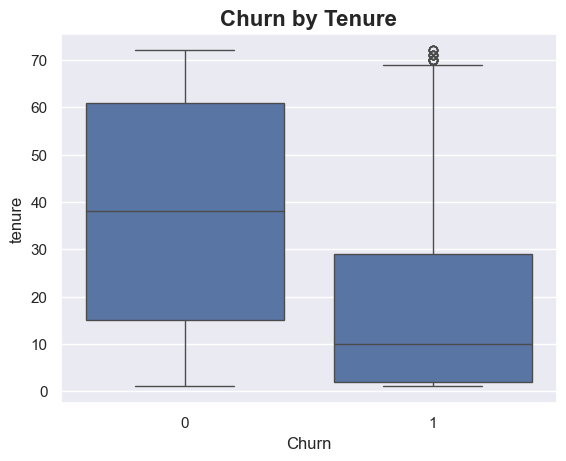

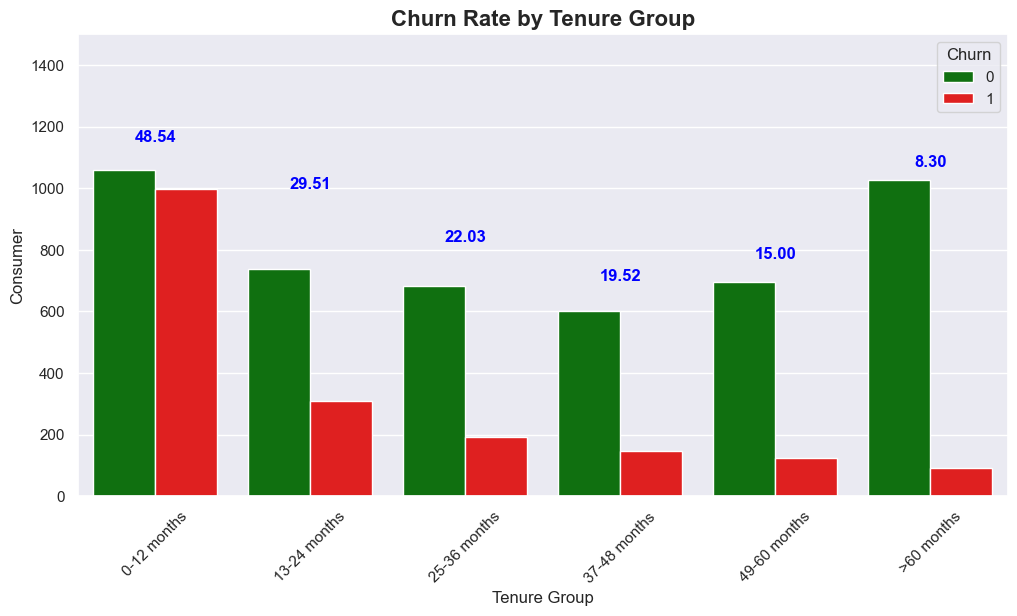

In [2]:
# Correlations 

numerical_features = ["tenure", "MonthlyCharges", "Churn"]
# numerical data frame
df_numerical = df[numerical_features]

# correlation heatmap
corr_matrix = df_numerical.corr(numeric_only=True)
sns.heatmap(corr_matrix)
plt.title("Correlation Heatmap", fontsize=16, fontweight="bold")
plt.show()

# box plot 
sns.boxplot(x="Churn", y="tenure", data=df_numerical)
plt.title("Churn by Tenure", fontsize=16, fontweight="bold")
plt.show()


# bar chart
# create bins of size 12 for tenure
bins = [0, 12, 24, 36, 48, 60, df['tenure'].max()]
labels = ['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '>60 months']

# create a new column for grouped tenure
df_numerical["tenure_group"] = pd.cut(df["tenure"], bins=bins, labels=labels, right=False)

# calculate churn rates for each tenure group 
churn_rates = (
    df_numerical.groupby("tenure_group")["Churn"]
    .agg(total_customers="size", churned_customers="sum") # get size of total rows, and then sum the churned customers
    .reset_index()
)
churn_rates["churn_rate"] = churn_rates["churned_customers"]  / churn_rates["total_customers"] * 100 # new column of churn rates

# visualisation
# initalise figure
plt.figure(figsize=(12,6))
ax = sns.countplot(x="tenure_group", hue="Churn", data=df_numerical, palette=["green", "red"])

# add churn rate to the figure
for i, tenure_group in enumerate(churn_rates["tenure_group"]):
    # total customers and churn rate for current group
    total_customers = churn_rates.loc[churn_rates["tenure_group"] == tenure_group, "total_customers"].values[0]
    churn_rate = churn_rates.loc[churn_rates["tenure_group"] == tenure_group, "churn_rate"].values[0]

    # position churn rate 
    ax.text(
        i,
        min(total_customers, 1200) - 50,
        f"{churn_rate:.2f}",
        ha="center",
        fontsize=12,
        fontweight="bold",
        color="blue"
    )


plt.xlabel("Tenure Group")
plt.ylabel("Consumer")
plt.title("Churn Rate by Tenure Group", fontsize=16, fontweight="bold")
plt.ylim(0,1500)
plt.xticks(rotation=45)
plt.show()

1) Tenure and monthly charge has a correlation of 0.247 -> weak positive correlation, **suggesting customers with longer tenures tend to have slightly higher monthly charges**


2) Tenure and churn has a correlation of -0.354 -> moderate negative correlation, **suggesting customers with longer tenures are less likely to churn**
<br><br>*Exploring this correlation w/ 2 other graphs*<br><br>
    From the box plot:
    - Customers who did not churn have a wider range of tenures, with a median about 40 months. The IQR is broad, so many customers stayed for extended periods as tenure values are spread accross a long period.
    - Customers who churned have a lower median tenure, around 10 months. IQR is smaller so customers who churn will do so quickly. There are some outliers who have longer tenures but still churned, suggesitng long-term customers could be leaving due to other factors 

    From the count plot:
    - Churn rate decreases as tenure increases 

    Therefore, we can conclude, in general, **customers with longer tenures are less likely to churn**
<br>

3) Monthly charge and churn has a correlation of 0.193 -> weak positive correlation, **suggesting customers with higher monthly charges are slightly more likely to churn**

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


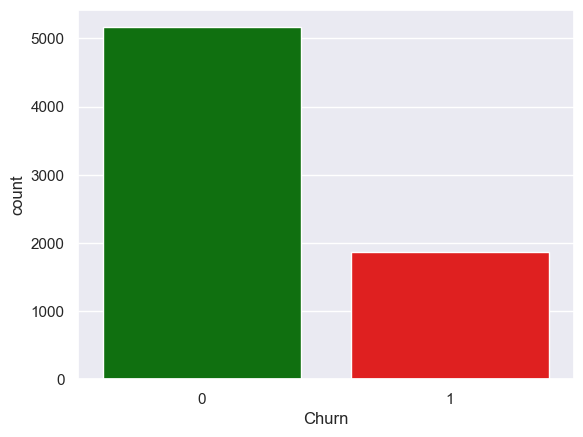

In [5]:
# summary stats
print(df["Churn"].value_counts(normalize=True)) 
sns.countplot(x="Churn", data=df, palette=["green", "red"])
plt.show()

The churn rate distribution shows 26.58% of customers churned whilst 73.42% have stayed. This shows there is an inbalanced distirbution, which can impact the predictive models. We will have to deal with this later.

### Categorical Features

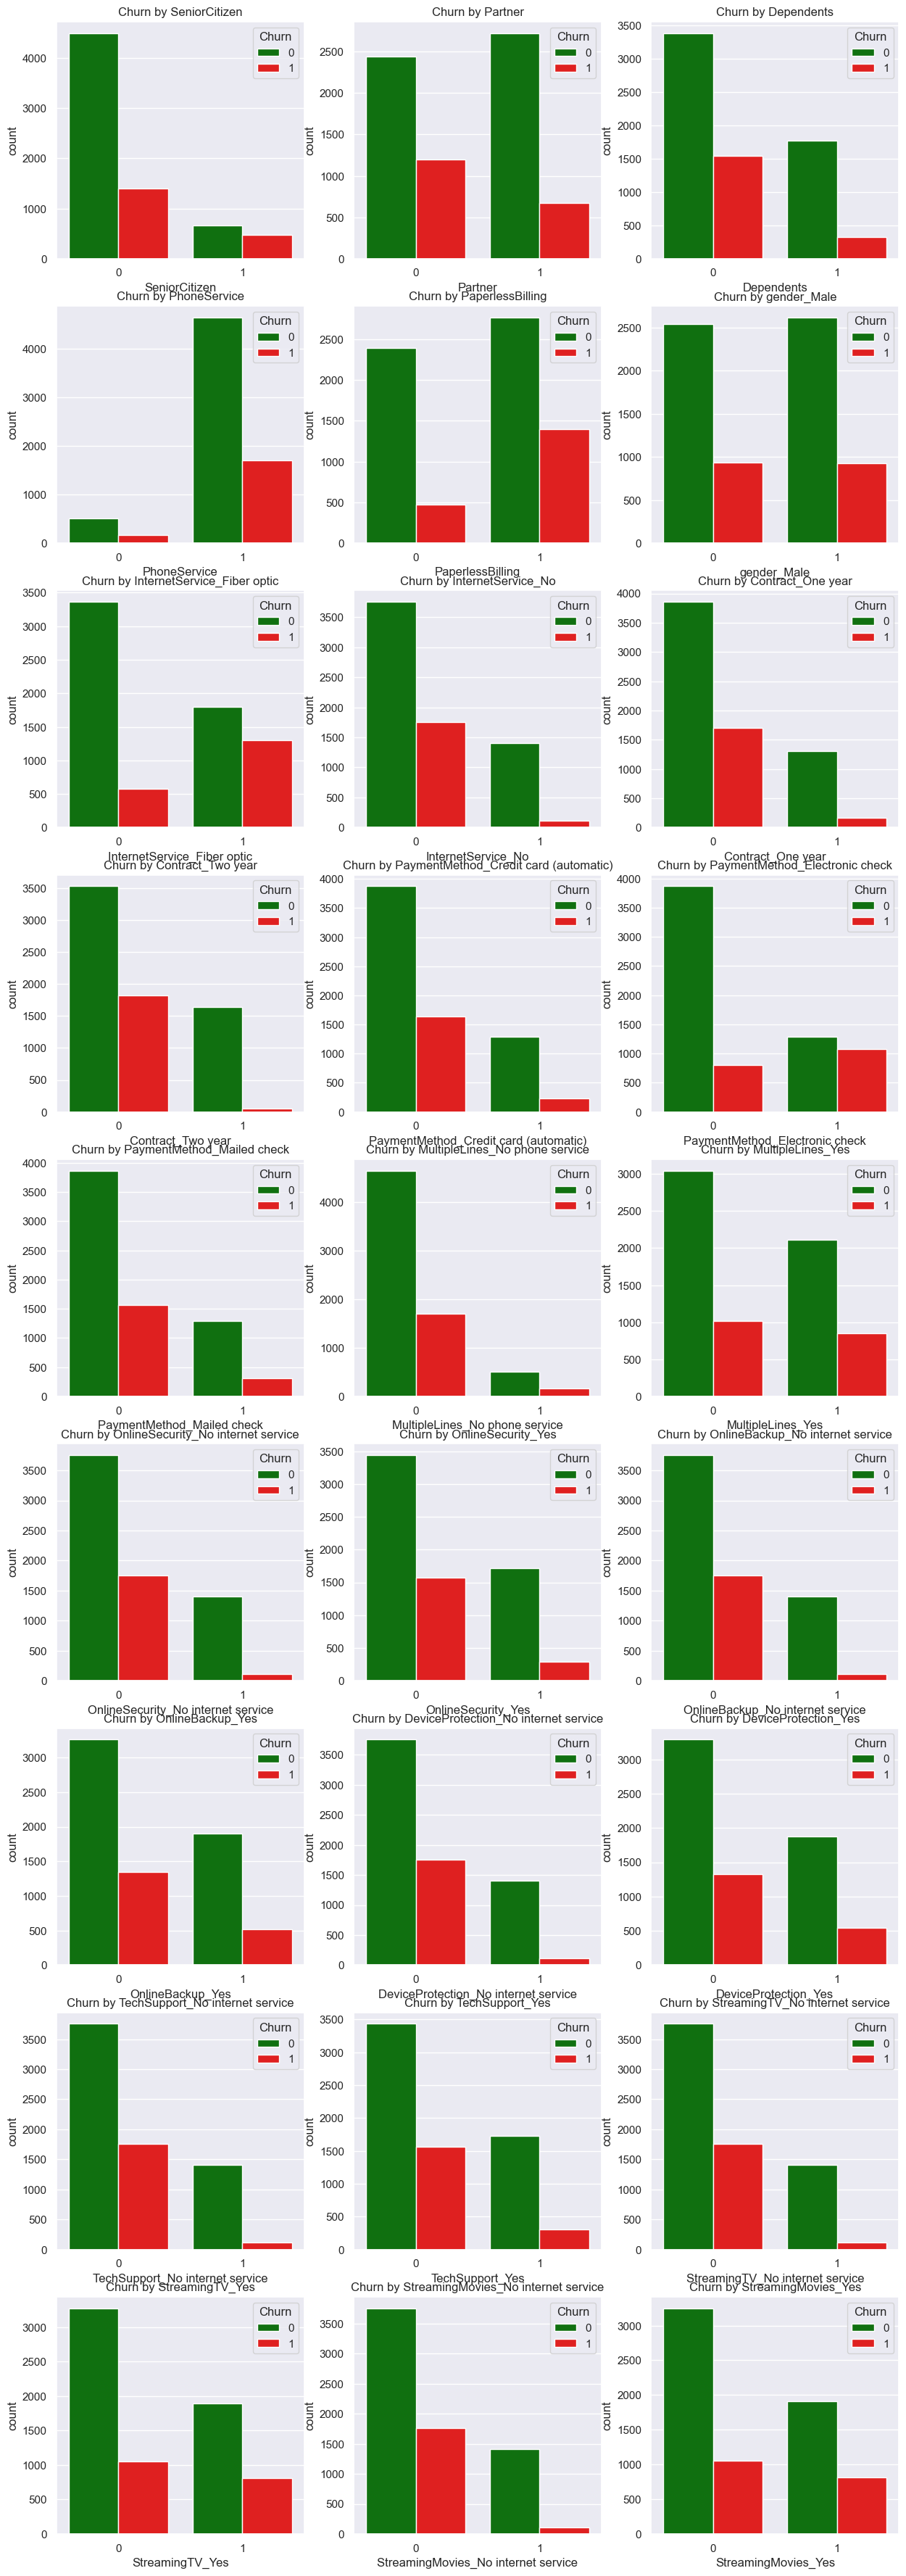

In [14]:
# identify cateogrical features
categorical_features = [col for col in df.columns if df[col].nunique() <= 2 and col!= "Churn"]

# get rows and columns for subplots
num_features = len(categorical_features)
cols = 3
rows=math.ceil(num_features/cols)

# subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols *5, rows*5))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue="Churn", data=df, palette=["green", "red"], ax=axes[i])
    axes[i].set_title(f"Churn by {feature}")

plt.tight_layout
plt.show()


There's alot of observations, i'll highlight the important ones:

1) Senior citizens have higher churn rates, suggesting older cistomers may find the service less appealing 

2) Customers without partners or dependents churn more

3) Internet service impacts churn:
    - Fiber optic users has the highest churn rate, compared to DLS and no internet service

4) Two year contracts have lowest churn rates, and looking at one year contract, their churn rate is also low. Therefore, the baseline category (month-month) that was removed due to one-hot-encoding has the highest churn rate, which makes sense, as long term contracts reduce churn due to commitemens and our previous charts showed churn rate drops as consumers stay longer

5) Customers with paperless billing (1) churn more than those recieving paper bills (0), could be because digital billing makes it easier to switch services. 

6) Electronic check users have the highest churn rate compared to all the other categories, which could be due to frustration with the payment system, as opposed to other payment methods - but it is an uncommon payment method, so it could be skewed 